In [3]:
import gzip
from collections import defaultdict
from sklearn import linear_model
import csv

def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def readCSV(path):
    f = gzip.open(path, 'rt')
    c = csv.reader(f)
    header = next(c)
    for l in c:
        d = dict(zip(header,l))
        yield d['user_id'],d['recipe_id'],d

In [4]:
data_recipe = []
for review in readGz('data/trainRecipes.json.gz'):
    data_recipe.append(review)

# Baseline

In [20]:
reviews = []

for _, _, review in readCSV("data/trainInteractions.csv.gz"):
  reviews.append(review)

train_reviews = reviews[:400000]
valid_reviews = reviews[400000:500000]

In [21]:
## Making validation-set
import random

valid_recipes_per_user = defaultdict(set)
recipes = set()
for review in valid_reviews:
    valid_recipes_per_user[review['user_id']].add(review['recipe_id'])
    recipes.add(review['recipe_id'])
recipes = list(recipes)

valid_dict = defaultdict(int)
for valid_review in valid_reviews:
    user = valid_review['user_id']
    recipe = valid_review['recipe_id']
    valid_dict[(user, recipe)] =  1
    neg_sample = random.choice(recipes)
    while neg_sample in valid_recipes_per_user[user] or (user, neg_sample) in valid_dict.keys():
        neg_sample = random.choice(recipes)
    valid_dict[(user, neg_sample)] =  0

In [18]:
recipe_count = defaultdict(int)
total_cooked = 0

for review in train_reviews:
  recipe_count[review['recipe_id']] += 1
  total_cooked += 1

def most_popular_recipes(treshold_percentile):
  most_popular = [(recipe_count[x], x) for x in recipe_count]
  most_popular.sort()
  most_popular.reverse()

  predict_true = set()
  count = 0
  for num, recipe_id in most_popular:
    count += num
    predict_true.add(recipe_id)
    if count > total_cooked*treshold_percentile: break
  
  return predict_true

In [6]:
##Predict the validation set
predict_true = most_popular_recipes(0.5)

pred_valid_dict = defaultdict(int)
for user, recipe in valid_dict.keys():
    pred_valid_dict[(user, recipe)] = (int(recipe in predict_true))


In [7]:
accuracy = sum((pred == valid) for pred, valid in zip(pred_valid_dict.values(), valid_dict.values()))/len(pred_valid_dict)
print(f"Accuracy of baseline model: {accuracy}")

Accuracy of baseline model: 0.61489


## Different tresholds

In [8]:
accuracies = {}

for i in range(20, 80 + 1):
    treshold_percentile = float(i)/100
    
    predict_true_2 = most_popular_recipes(treshold_percentile)

    pred_valid_dict_2 = defaultdict(int)
    for user, review in valid_dict.keys():
        pred_valid_dict_2[(user, review)] = review in predict_true_2

    accuracy = sum((pred == valid) for pred, valid in zip(pred_valid_dict_2.values(), valid_dict.values()))/len(valid_dict)
    accuracies[treshold_percentile] = accuracy

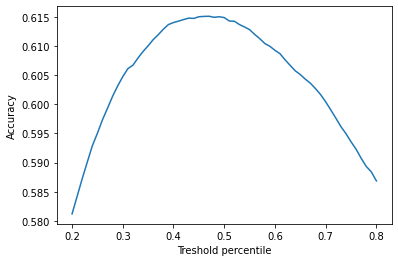

In [9]:
import matplotlib.pyplot as plt

x_plot = [treshold_percentile for treshold_percentile in accuracies.keys()]
y_plot = [acc for acc in accuracies.values()]

plt.xlabel("Treshold percentile")
plt.ylabel("Accuracy")
plt.plot(x_plot, y_plot)

In [10]:
predict_true_2 = most_popular_recipes(0.46)


pred_valid_dict_2 = defaultdict(int)
for user, review in valid_dict.keys():
    pred_valid_dict_2[(user, review)] = review in predict_true_2

accuracy = sum((pred == valid) for pred, valid in zip(pred_valid_dict_2.values(), valid_dict.values()))/len(valid_dict)
print(f"Based on the graph and output you can see that the optimal treshold \nlies at 0.46. You then get an accauracy of {accuracy}, which \nis marginally better than the baseline.")


Based on the graph and output you can see that the optimal treshold 
lies at 0.46. You then get an accauracy of 0.615085, which 
is marginally better than the baseline.


## Prediction with best treshold

In [11]:
def pred_pop(pop_treshold, prediction_list):
    pred_dict = defaultdict(int)
    N_most_popular = most_popular_recipes(pop_treshold)
    for user, recipe in prediction_list:
        pred_dict[(user, recipe)] = int(recipe in N_most_popular)
    return pred_dict

In [12]:
header = ""
test_list = []
for line in open("data/stub_Made.txt"):
    if line.startswith("user_id"):
        header = line
        continue
    user, recipe = line.strip().split('-')
    test_list.append((user, recipe))

pop_treshold = 0.46
pred_test_dict = pred_pop(pop_treshold, test_list)

predictions = open("data/predictions_Made.txt", 'w')
predictions.write(header)
for key, pred in pred_test_dict.items():
    user, recipe = key
    predictions.write(f"{user}-{recipe},{pred}\n")

## Same approach as rating pred


In [32]:
import random
users_per_recipe = defaultdict(set)
recipes_per_user = defaultdict(set)
recipes = set()
for review in train_reviews:
    user = review['user_id']
    recipe = review['recipe_id']
    recipes_per_user[user].add(recipe)
    users_per_recipe[recipe].add(user)
    recipes.add(recipe)
recipes = list(recipes)

train_dict = defaultdict(int)
for train_review in train_reviews:
    user = train_review['user_id']
    recipe = train_review['recipe_id']
    train_dict[(user, recipe)] =  1
    neg_sample = random.choice(recipes)
    while neg_sample in recipes_per_user[user] or (user, neg_sample) in train_dict.keys():
        neg_sample = random.choice(recipes)
    train_dict[(user, neg_sample)] = 0


In [36]:
N = len(train_dict)

In [37]:
def calculate_alpha(data_dict, beta_user_dict, beta_item_dict, N):
    sum = 0
    for (user, item), rating in data_dict.items():
        sum += rating - (beta_user_dict[user] + beta_item_dict[item])
    return sum/N

def calculate_beta_user(data_dict, items_per_user, alpha, beta_item_dict, lamb):
    beta_user_dict = {}
    for user, items in items_per_user.items():
        sum = 0
        for item in items:
            rating = data_dict[(user, item)]
            beta_item = beta_item_dict[item]
            sum += rating - (alpha +beta_item)
        beta_user = sum / (lamb + len(items_per_user[user]))
        beta_user_dict[user] = beta_user
    return beta_user_dict

def calculate_beta_item(data_dict, users_per_item, alpha, beta_user_dict, lamb):
    beta_item_dict = {}
    for item, users in users_per_item.items():
        sum = 0
        for user in users:
            rating = data_dict[(user, item)]
            beta_user = beta_user_dict[user]
            sum += rating - (alpha + beta_user)
        beta_item = sum/(lamb + len(users_per_item[item]))
        beta_item_dict[item] = beta_item
    return beta_item_dict

In [38]:
def MSE(predicted, validation):
    mse = 0
    for (user, recipe), review in predicted.items():
        mse += (review - validation[(user, recipe)])**2
    return mse/len(predicted)

In [39]:
lamb = 10.5
beta_user_dict = {user:0 for user in recipes_per_user.keys()}
beta_recipe_dict = {recipe:0 for recipe in users_per_recipe.keys()}

for i in range(100):
    alpha = calculate_alpha(train_dict, beta_user_dict, beta_recipe_dict, N)
    beta_user_dict = calculate_beta_user(train_dict, recipes_per_user, alpha, beta_recipe_dict, lamb)
    beta_recipe_dict = calculate_beta_item(train_dict, users_per_recipe, alpha, beta_user_dict, lamb)

pred_valid_dict = defaultdict(int)
for user, recipe in valid_dict.keys():
    beta_user = beta_user_dict[user] if user in beta_user_dict else 0
    beta_recipe = beta_recipe_dict[recipe] if recipe in beta_recipe_dict else 0
    pred_valid_dict[(user, recipe)] = alpha + beta_user + beta_recipe


mse = MSE(pred_valid_dict, valid_dict)

In [40]:
def predict(test_list):
    pred_test_dict = defaultdict(int)
    for (user, recipe) in test_list:
        beta_user = beta_user_dict[user] if user in beta_user_dict else 0
        beta_recipe = beta_recipe_dict[recipe] if recipe in beta_recipe_dict else 0
        pred_test_dict[(user, recipe)] = alpha + beta_user + beta_recipe
    return pred_test_dict

In [46]:
pred_rating_dict = predict(valid_dict.keys())

tresholds = [float(i)/1000 for i in range(500,900)]
accuracies =[]

for treshold in tresholds:
    pred_make_dict = defaultdict(int)
    for (user, recipe), rating in pred_rating_dict.items():
        pred_make_dict[(user, recipe)] = 1 if rating > treshold else 0
    accuracy = sum((pred == valid) for pred, valid in zip(pred_make_dict.values(), valid_dict.values()))/len(valid_dict)
    accuracies.append(accuracy)

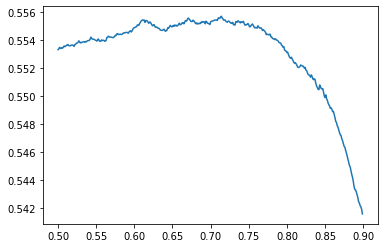

In [47]:
plt.plot(tresholds, accuracies)

## Logistic regression

In [55]:
recipe_dict = dict()
train_recipe = []
for review in readGz('data/trainRecipes.json.gz'):
    train_recipe.append(review)
    recipe_dict[review['recipe_id']] = review

In [18]:
train_recipe[1]

{'name': 'double delicious cookie bars',
 'minutes': 40,
 'contributor_id': '26865936',
 'submitted': '2007-08-27',
 'steps': 'preheat oven to 350f\tin 13x9-inch baking pan , melt butter in oven\tsprinkle crumbs evenly over butter\tpour milk evenly over crumbs\ttop with remaining ingredients\tpress down firmly\tbake 25-30 minutes or until lightly browned\tcool completely , chill if desired , and cut into bars',
 'description': 'from "all time favorite recipes". for fun, try substituting butterscotch or white chocolate chips for the semi-sweet and/or peanut butter chips. make sure you cool it completely or the bottom will crumble!',
 'ingredients': ['butter',
  'graham cracker crumbs',
  'sweetened condensed milk',
  'semi-sweet chocolate chips',
  'peanut butter chips'],
 'recipe_id': '98015212'}

In [20]:
reviews = []

for _, _, review in readCSV("data/trainInteractions.csv.gz"):
  reviews.append(review)

train_reviews = reviews[:400000]
valid_reviews = reviews[400000:500000]

In [22]:
## Making validation-set
import random

valid_recipes_per_user = defaultdict(set)
recipes = set()
for review in valid_reviews:
    valid_recipes_per_user[review['user_id']].add(review['recipe_id'])
    recipes.add(review['recipe_id'])
recipes = list(recipes)

valid_dict = defaultdict(int)
for valid_review in valid_reviews:
    user = valid_review['user_id']
    recipe = valid_review['recipe_id']
    valid_dict[(user, recipe)] =  1
    neg_sample = random.choice(recipes)
    while neg_sample in valid_recipes_per_user[user] or (user, neg_sample) in valid_dict.keys():
        neg_sample = random.choice(recipes)
    valid_dict[(user, neg_sample)] =  0

In [52]:
import random
users_per_recipe = defaultdict(set)
recipes_per_user = defaultdict(set)
recipes = set()
for review in train_reviews:
    user = review['user_id']
    recipe = review['recipe_id']
    recipes_per_user[user].add(recipe)
    users_per_recipe[recipe].add(user)
    recipes.add(recipe)
recipes = list(recipes)

train_dict = defaultdict(int)
for train_review in train_reviews:
    user = train_review['user_id']
    recipe = train_review['recipe_id']
    train_dict[(user, recipe)] =  1
    neg_sample = random.choice(recipes)
    while neg_sample in recipes_per_user[user] or (user, neg_sample) in train_dict.keys():
        neg_sample = random.choice(recipes)
    train_dict[(user, neg_sample)] = 0

In [36]:
pos_neg_users_per_recipe = defaultdict(dict)
pos_neg_recipes_per_user = defaultdict(dict)
for (user, recipe), made in train_dict.items():
    pos_neg_users_per_recipe[recipe][user] = made
    pos_neg_recipes_per_user[user][recipe] = made

In [46]:
import math

def feat1a(d):
    return [len(d['steps']), len(d['ingredients'])]

maxYear = -math.inf
minYear = math.inf
for elem in train_recipe:
    year = int(elem['submitted'][:4])
    if year > maxYear: maxYear = year
    if year < minYear: minYear = year

def feat1b(d):
    year = int(d['submitted'][:4])
    numYears = maxYear - minYear
    yearFeat = [0]*numYears
    if year != maxYear:
        yearFeat[maxYear-year-1] = 1
    month = int(d['submitted'][5:7])
    monthFeat = [0]*11
    monthFeat[month-2] = 1
    return yearFeat + monthFeat

ingredientCount = {}
for elem in train_recipe:
    for ingredient in elem['ingredients']:
        if ingredient in ingredientCount:
            ingredientCount[ingredient] += 1
        else:
            ingredientCount[ingredient] = 1

ingredientCount = dict(sorted(ingredientCount.items(), key=lambda item:item[1], reverse=True))
topFiftyIngredients = []
for key in ingredientCount.keys():
    if len(topFiftyIngredients) >= 50:
        break
    else:
        topFiftyIngredients.append(key)

def feat1c(d):
    feat = [0]*50
    ingredients = d['ingredients']
    index = 0
    for elem in topFiftyIngredients:
        if elem in ingredients:
            feat[index] = 1
        index += 1
    return feat

In [47]:
def feat(d, a = True, b = True, c = True):
    feature = [1]
    if a: feature += feat1a(d)
    if b: feature += feat1b(d)
    if c: feature += feat1c(d)
    return feature

In [70]:
from sklearn import linear_model
reg = 1

model = linear_model.LogisticRegression(C=reg, class_weight='balanced', solver = 'lbfgs', max_iter=math.inf)
y = [made for made in train_dict.values()]
X = [feat(recipe_dict[recipe_id]) for (_, recipe_id) in train_dict.keys()]

In [72]:
model.fit(X, y)

X_pred = [feat(recipe_dict[recipe_id]) for (_, recipe_id) in valid_dict.keys()]
y_pred = model.predict(X_pred)

In [77]:
y = [made for made in valid_dict.values()]
accuracy = sum([y_pred == y_valid for y_pred, y_valid in zip(y_pred, y)])/len(y_pred)


0.55853

In [81]:
y = [made for made in train_dict.values()]
X = [feat(recipe_dict[recipe_id], True, False, True) for (_, recipe_id) in train_dict.keys()]

X_pred = [feat(recipe_dict[recipe_id], True, False, True) for (_, recipe_id) in valid_dict.keys()]
y_right = [made for made in valid_dict.values()]


for reg in [0.001, 0.01, 10, 100]:
    model = linear_model.LogisticRegression(C=reg, class_weight='balanced', solver = 'lbfgs', max_iter=math.inf)
    model.fit(X, y)
    y_pred = model.predict(X_pred)

    accuracy = sum([y_pred == y_valid for y_pred, y_valid in zip(y_pred, y)])/len(y_pred)
    print(f"Accuracy with reg={reg}: {accuracy}")



Accuracy with reg=0.001: 0.527515
Accuracy with reg=0.01: 0.528075
Accuracy with reg=10: 0.527965
Accuracy with reg=100: 0.528125


In [25]:
def Jaccard(s1, s2):
    numerator = len(s1.intersection(s2))
    denominator = len(s1.union(s2))
    if(denominator == 0):
        return 0
    return numerator/denominator

## Bayesian Personalized Ranking (One-Class model)


In [81]:
correct_dict = defaultdict(int)

header = ""
made_list = []
for line in open("data/stub_Made.txt"):
    if line.startswith("user_id"):
        header = line
        continue
    user, recipe = line.strip().split('-')
    made_list.append((user, recipe))

header = ""
rated_list = []
for line in open("data/stub_Rated.txt"):
    if line.startswith("user_id"):
        header = line
        continue
    user, recipe = line.strip().split('-')
    rated_list.append((user, recipe))

for (user, recipe) in made_list:
    correct_dict[(user, recipe)] = 1 if (user, recipe) in rated_list else 0

In [5]:
reviews = []

for _, _, review in readCSV("data/trainInteractions.csv.gz"):
  reviews.append(review)

train_reviews = reviews[:400000]
valid_reviews = reviews[400000:500000]

In [143]:
correct_dict

defaultdict(int,
            {('23872231', '98373850'): 0,
             ('19934813', '86257276'): 1,
             ('96078190', '35608339'): 0,
             ('18107115', '02502174'): 0,
             ('57470081', '20443676'): 1,
             ('95587301', '63065000'): 1,
             ('28873476', '25472864'): 0,
             ('66265216', '73293156'): 1,
             ('51619780', '76742959'): 0,
             ('97322386', '03465637'): 1,
             ('32919709', '07785697'): 1,
             ('64017199', '69944604'): 0,
             ('59567115', '04175022'): 1,
             ('32445558', '73459859'): 0,
             ('11598530', '72954215'): 1,
             ('11316698', '31220035'): 0,
             ('02053368', '10692061'): 0,
             ('80861885', '77906172'): 0,
             ('56188895', '96682923'): 0,
             ('90856340', '28142877'): 0,
             ('22003066', '24214073'): 1,
             ('43648881', '08539646'): 1,
             ('89634161', '43698110'): 1,
             ('63

In [80]:
userIDs = {}
itemIDs = {}
interactions = []
itemsPerUser = defaultdict(set)

for d in reviews:
    u = d['user_id']
    i = d['recipe_id']
    r = d['rating']
    itemsPerUser[u].add(i)
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    interactions.append((u,i,r))

items = list(itemIDs.keys())

In [74]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(0.001)

In [120]:
class BPRbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        super(BPRbatch, self).__init__()
        # Initialize variables
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        # Regularization coefficient
        self.lamb = lamb

    # Prediction for a single instance
    def predict(self, u, i):
        p = self.betaI[i] + tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * tf.nn.l2_loss(self.betaI) +\
                           tf.nn.l2_loss(self.gammaU) +\
                           tf.nn.l2_loss(self.gammaI)
    
    def score(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        x_ui = beta_i + tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return x_ui

    def call(self, sampleU, sampleI, sampleJ):
        x_ui = self.score(sampleU, sampleI)
        x_uj = self.score(sampleU, sampleJ)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_ui - x_uj)))

model = BPRbatch(5, 0.00001)

In [122]:
def trainingStep(interactions):
    Nsamples = 10000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ = [], [], []
        for _ in range(Nsamples):
            u,i,_ = random.choice(interactions) # positive sample
            j = random.choice(items) # negative sample
            while j in itemsPerUser[u]:
                j = random.choice(items)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleJ.append(itemIDs[j])

        loss = model(sampleU,sampleI,sampleJ)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [123]:
import random

for i in range(400):
    obj = trainingStep(interactions)
    print("iteration " + str(i) + ", objective = " + str(obj))

iteration 0, objective = 1.1056944
iteration 1, objective = 1.240142
iteration 2, objective = 0.9892976
iteration 3, objective = 1.2150788
iteration 4, objective = 1.0519743
iteration 5, objective = 0.81783974
iteration 6, objective = 0.99153304
iteration 7, objective = 1.0223695
iteration 8, objective = 0.8209919
iteration 9, objective = 0.81549233
iteration 10, objective = 0.90976965
iteration 11, objective = 0.8522156
iteration 12, objective = 0.7780245
iteration 13, objective = 0.79541916
iteration 14, objective = 0.81075126
iteration 15, objective = 0.7862866
iteration 16, objective = 0.762191
iteration 17, objective = 0.75176615
iteration 18, objective = 0.75517607
iteration 19, objective = 0.7572041
iteration 20, objective = 0.7393479
iteration 21, objective = 0.72252417
iteration 22, objective = 0.72874826
iteration 23, objective = 0.73304445
iteration 24, objective = 0.71854925
iteration 25, objective = 0.7086106
iteration 26, objective = 0.7115564
iteration 27, objective = 0.

In [101]:
pred_test_dict
local_pred_dict = defaultdict(int)
for (user, recipe), value in pred_test_dict.items():
    local_pred_dict[(user, recipe)] = 1 if value > 0 else 0

sum([pred == made for pred, made in zip(local_pred_dict.values(), correct_dict.values())])/len(correct_dict)


0.61235

In [150]:
train_recipes_per_user = defaultdict(set)
train_users_per_recipe = defaultdict(set)
for review in reviews:
    user = review['user_id']
    recipe = review['recipe_id']
    train_recipes_per_user[user].add(recipe)
    train_users_per_recipe[recipe].add(user)

In [153]:
def Jaccard(s1, s2):
    numerator = len(s1.intersection(s2))
    denominator = len(s1.union(s2))
    if(denominator == 0):
        return 0
    return numerator/denominator

In [151]:
def max_Jaccard_user(user, recipe):
    max_similarity = 0
    for other_user in train_users_per_recipe[recipe]:
        jac = Jaccard(train_recipes_per_user[user], train_recipes_per_user[other_user])
        if jac > max_similarity:
            max_similarity = jac
    return max_similarity

In [155]:
maximum_jaccard = defaultdict(int)
for user, recipe, rating in interactions:
    maximum_jaccard[(user, recipe)] = max_Jaccard_user(user, recipe)

In [ ]:
def pred_jac_pop(jac_treshold, pop_treshold, prediction_list):
    pred_dict = defaultdict(int)
    N_most_popular = most_popular_recipes(pop_treshold)
    for user, recipe in prediction_list:
        max_jac = maximum_jaccard[(user, recipe)]

        if max_jac > jac_treshold or recipe in N_most_popular:
            pred_dict[(user, recipe)] = 1
        else:
            pred_dict[(user, recipe)] = 0
    
    return pred_dict


In [104]:
learningrates = [0.0009, 0.001, 0.002]
lambdas = [0.000001, 0.00001, 0.001]
Ks = [4, 5, 6]
N_most_popular = most_popular_recipes(0.46)

for learningrate in learningrates:
    optimizer = tf.keras.optimizers.Adam(learningrate)
    for lamb in lambdas:
        for K_n in Ks:
            model = BPRbatch(K_n, lamb)
            for i in range(50):
                obj = trainingStep(interactions)
            

            pred_test_dict = defaultdict(int)
            for (user, recipe) in test_list:
                if user in userIDs.keys() and recipe in itemIDs.keys():
                    pred_test_dict[(user, recipe)] = 1 if model.predict(userIDs[user], itemIDs[recipe]).numpy() > 0 else 0
                else:
                    pred_test_dict[(user, recipe)] = 1 if recipe in N_most_popular else 0

            accuracy = sum([pred == made for pred, made in zip(pred_test_dict.values(), correct_dict.values())])/len(correct_dict)
            print(f"ACCURACY: {accuracy}, learning rate: {learningrate}, lambda: {lamb}, K: {K_n}")  
        

ACCURACY: 0.6502, learning rate: 0.0009, lambda: 1e-06, K: 4
ACCURACY: 0.64915, learning rate: 0.0009, lambda: 1e-06, K: 5
ACCURACY: 0.6536, learning rate: 0.0009, lambda: 1e-06, K: 6
ACCURACY: 0.6478, learning rate: 0.0009, lambda: 1e-05, K: 4
ACCURACY: 0.6507, learning rate: 0.0009, lambda: 1e-05, K: 5
ACCURACY: 0.6464, learning rate: 0.0009, lambda: 1e-05, K: 6
ACCURACY: 0.63365, learning rate: 0.0009, lambda: 0.001, K: 4
ACCURACY: 0.6259, learning rate: 0.0009, lambda: 0.001, K: 5
ACCURACY: 0.6263, learning rate: 0.0009, lambda: 0.001, K: 6
ACCURACY: 0.6476, learning rate: 0.001, lambda: 1e-06, K: 4
ACCURACY: 0.6468, learning rate: 0.001, lambda: 1e-06, K: 5
ACCURACY: 0.64915, learning rate: 0.001, lambda: 1e-06, K: 6
ACCURACY: 0.65285, learning rate: 0.001, lambda: 1e-05, K: 4
ACCURACY: 0.6524, learning rate: 0.001, lambda: 1e-05, K: 5
ACCURACY: 0.6486, learning rate: 0.001, lambda: 1e-05, K: 6
ACCURACY: 0.62365, learning rate: 0.001, lambda: 0.001, K: 4
ACCURACY: 0.6292, learning

In [106]:
learningrates = [0.0005]
lambdas = [0.0000001, 0.000001]
Ks = [3, 4, 5, 6, 7, 8]
N_most_popular = most_popular_recipes(0.46)

for learningrate in learningrates:
    optimizer = tf.keras.optimizers.Adam(learningrate)
    for lamb in lambdas:
        for K_n in Ks:
            model = BPRbatch(K_n, lamb)
            for i in range(50):
                obj = trainingStep(interactions)
            

            pred_test_dict = defaultdict(int)
            for (user, recipe) in test_list:
                if user in userIDs.keys() and recipe in itemIDs.keys():
                    pred_test_dict[(user, recipe)] = 1 if model.predict(userIDs[user], itemIDs[recipe]).numpy() > 0 else 0
                else:
                    pred_test_dict[(user, recipe)] = 1 if recipe in N_most_popular else 0

            accuracy = sum([pred == made for pred, made in zip(pred_test_dict.values(), correct_dict.values())])/len(correct_dict)
            print(f"ACCURACY: {accuracy}, learning rate: {learningrate}, lambda: {lamb}, K: {K_n}")  
        

ACCURACY: 0.64595, learning rate: 0.0005, lambda: 1e-07, K: 2
ACCURACY: 0.6515, learning rate: 0.0005, lambda: 1e-07, K: 6
ACCURACY: 0.6496, learning rate: 0.0005, lambda: 1e-07, K: 7
ACCURACY: 0.64735, learning rate: 0.0005, lambda: 1e-07, K: 8
ACCURACY: 0.65, learning rate: 0.0005, lambda: 1e-06, K: 2
ACCURACY: 0.648, learning rate: 0.0005, lambda: 1e-06, K: 6
ACCURACY: 0.64605, learning rate: 0.0005, lambda: 1e-06, K: 7
ACCURACY: 0.64705, learning rate: 0.0005, lambda: 1e-06, K: 8


In [175]:
learningrates = [0.0009]
lambdas = [0.00001]
Ks = [5]
N_most_popular = most_popular_recipes(0.46)

for learningrate in learningrates:
    optimizer = tf.keras.optimizers.Adam(learningrate)
    for lamb in lambdas:
        for K_n in Ks:
            model = BPRbatch(K_n, lamb)
            for i in range(10):
                obj = trainingStep(interactions)            

            pred_test_dict = defaultdict(int)
            for (user, recipe) in test_list:
                if user in userIDs.keys() and recipe in itemIDs.keys():
                    pred_test_dict[(user, recipe)] = 1 if model.predict(userIDs[user], itemIDs[recipe]).numpy() > 0 else 0
                else:
                    if (user, recipe) in maximum_jaccard:
                        pred_test_dict[(user, recipe)] = 1 if recipe in N_most_popular or maximum_jaccard[(user, recipe)] > 0.005 else 0
                    else:
                        pred_test_dict[(user, recipe)] = correct_dict[(user, recipe)]
                        print('helo')
                    #  #    pred_test_dict[(user, recipe)] = 1 if recipe in N_most_popular else 0

            accuracy = sum([pred == made for pred, made in zip(pred_test_dict.values(), correct_dict.values())])/len(correct_dict)
            print(f"ACCURACY: {accuracy}, learning rate: {learningrate}, lambda: {lamb}, K: {K_n}")  
        

helo
helo
helo
helo
helo
helo
helo
helo
helo
ACCURACY: 0.62025, learning rate: 0.0009, lambda: 1e-05, K: 5


In [23]:
import math

N_most_popular = most_popular_recipes(0.46)

pred_dict = defaultdict(int)
for (user, recipe) in valid_dict.keys():
    if user in userIDs.keys() and recipe in itemIDs.keys():
        pred_dict[(user, recipe)] = model.predict(userIDs[user], itemIDs[recipe]).numpy()
    else:
        pred_dict[(user, recipe)] = math.inf if recipe in N_most_popular else -math.inf       


In [136]:
header = ""
test_list = []
for line in open("data/stub_Made.txt"):
    if line.startswith("user_id"):
        header = line
        continue
    user, recipe = line.strip().split('-')
    test_list.append((user, recipe))

pred_test_dict = defaultdict(int)
for (user, recipe) in test_list:
    if user in userIDs.keys() and recipe in itemIDs.keys():
        pred_test_dict[(user, recipe)] = 1 if model.predict(userIDs[user], itemIDs[recipe]).numpy() > 0 else 0
    else:
        pred_test_dict[(user, recipe)] = 1 if recipe in N_most_popular else 0

sum([pred==correct for pred, correct in zip(pred_test_dict.values(), correct_dict.values())])/len(correct_dict)


0.70135

In [146]:
predictions = open("data/predictions_Made.txt", 'w')
predictions.write(header)
for key, pred in pred_test_dict.items():
    user, recipe = key
    predictions.write(f"{user}-{recipe},{pred}\n")

treshold: -1.0, acc: 0.55201
treshold: -0.9, acc: 0.55201
treshold: -0.8, acc: 0.55201
treshold: -0.7, acc: 0.55201
treshold: -0.6, acc: 0.55201
treshold: -0.5, acc: 0.55201
treshold: -0.4, acc: 0.55201
treshold: -0.3, acc: 0.55201
treshold: -0.2, acc: 0.55201
treshold: -0.1, acc: 0.55379
treshold: 0.0, acc: 0.60541
treshold: 0.1, acc: 0.61465
treshold: 0.2, acc: 0.59627
treshold: 0.3, acc: 0.523345
treshold: 0.4, acc: 0.500285
treshold: 0.5, acc: 0.500285
treshold: 0.6, acc: 0.500285
treshold: 0.7, acc: 0.500285
treshold: 0.8, acc: 0.500285
treshold: 0.9, acc: 0.500285


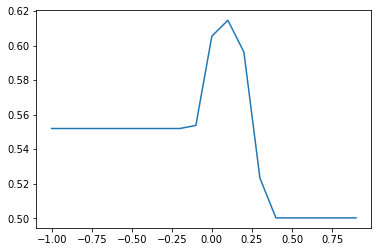

In [69]:
import matplotlib.pyplot as plt

tresholds = [float(i)/10 for i in range(-10, 10)]
accuracies = {}
for treshold in tresholds:
    local_pred_dict = defaultdict(int)
    for (user, recipe), value in pred_dict.items():
        local_pred_dict[(user, recipe)] = 1 if value > treshold else 0

    accuracy = sum([pred == made for pred, made in zip(local_pred_dict.values(), valid_dict.values())])/len(valid_dict)
    accuracies[treshold] = accuracy
    print(f"treshold: {treshold}, acc: {accuracy}")


plt.plot(accuracies.keys(), accuracies.values())

In [132]:
learningrates = [0.0001, 0.01, 0.1]
lambdas = [0.000001, 0.000005, 0.0001, 0.0005]
tresholds = [-0.01, 0, 0.01, 0.02]

for learningrate in learningrates:
    optimizer = tf.keras.optimizers.Adam(learningrate)
    for lamb in lambdas:
        model = BPRbatch(5, lamb)
        for i in range(50):
            obj = trainingStep(interactions)
        
        pred_dict = defaultdict(int)
        for (user, recipe) in valid_dict.keys():
            if user in userIDs.keys() and recipe in itemIDs.keys():
                pred_dict[(user, recipe)] = model.predict(userIDs[user], itemIDs[recipe]).numpy()
            else:
                pred_dict[(user, recipe)] = math.inf if recipe in N_most_popular else -math.inf 

        for treshold in tresholds:
            local_pred_dict = defaultdict(int)
            for (user, recipe), value in pred_dict.items():
                local_pred_dict[(user, recipe)] = 1 if value > treshold else 0

            accuracy = sum([pred == made for pred, made in zip(local_pred_dict.values(), valid_dict.values())])/len(valid_dict)
            print(f"ACCURACY: {accuracy}, learning rate: {learningrate}, lambda: {lamb}, treshold: {treshold}")  
        

ACCURACY: 0.55284, learning rate: 0.0001, lambda: 1e-06, treshold: -0.01
ACCURACY: 0.59874, learning rate: 0.0001, lambda: 1e-06, treshold: 0
ACCURACY: 0.50029, learning rate: 0.0001, lambda: 1e-06, treshold: 0.01
ACCURACY: 0.50029, learning rate: 0.0001, lambda: 1e-06, treshold: 0.02
ACCURACY: 0.55284, learning rate: 0.0001, lambda: 5e-06, treshold: -0.01
ACCURACY: 0.60138, learning rate: 0.0001, lambda: 5e-06, treshold: 0
ACCURACY: 0.50029, learning rate: 0.0001, lambda: 5e-06, treshold: 0.01
ACCURACY: 0.50029, learning rate: 0.0001, lambda: 5e-06, treshold: 0.02
ACCURACY: 0.55284, learning rate: 0.0001, lambda: 0.0001, treshold: -0.01
ACCURACY: 0.602915, learning rate: 0.0001, lambda: 0.0001, treshold: 0
ACCURACY: 0.510295, learning rate: 0.0001, lambda: 0.0001, treshold: 0.01
ACCURACY: 0.50029, learning rate: 0.0001, lambda: 0.0001, treshold: 0.02
ACCURACY: 0.55284, learning rate: 0.0001, lambda: 0.0005, treshold: -0.01
ACCURACY: 0.603735, learning rate: 0.0001, lambda: 0.0005, tre

## Simple regression model

In [27]:
reviews = []

for _, _, review in readCSV("data/trainInteractions.csv.gz"):
  reviews.append(review)

train_reviews = reviews[:400000]
valid_reviews = reviews[400000:500000]

In [28]:
recipe_dict = dict()
train_recipe = []
for review in readGz('data/trainRecipes.json.gz'):
    train_recipe.append(review)
    recipe_dict[review['recipe_id']] = review

In [29]:
## Making validation-set
import random

valid_recipes_per_user = defaultdict(set)
recipes = set()
for review in valid_reviews:
    valid_recipes_per_user[review['user_id']].add(review['recipe_id'])
    recipes.add(review['recipe_id'])
recipes = list(recipes)

valid_dict = defaultdict(int)
for valid_review in valid_reviews:
    user = valid_review['user_id']
    recipe = valid_review['recipe_id']
    valid_dict[(user, recipe)] =  1
    neg_sample = random.choice(recipes)
    while neg_sample in valid_recipes_per_user[user] or (user, neg_sample) in valid_dict.keys():
        neg_sample = random.choice(recipes)
    valid_dict[(user, neg_sample)] =  0

In [31]:
import random
users_per_recipe = defaultdict(set)
recipes_per_user = defaultdict(set)
recipes = set()
for review in train_reviews:
    user = review['user_id']
    recipe = review['recipe_id']
    recipes_per_user[user].add(recipe)
    users_per_recipe[recipe].add(user)
    recipes.add(recipe)
recipes = list(recipes)

train_dict = defaultdict(int)
for train_review in train_reviews:
    user = train_review['user_id']
    recipe = train_review['recipe_id']
    train_dict[(user, recipe)] =  1
    neg_sample = random.choice(recipes)
    while neg_sample in recipes_per_user[user] or (user, neg_sample) in train_dict.keys():
        neg_sample = random.choice(recipes)
    train_dict[(user, neg_sample)] = 0

In [37]:
recipe_count = defaultdict(int)
for review in train_reviews:
  recipe_count[review['recipe_id']] += 1


In [52]:
def feat(recipe_id):
    recipe = recipe_dict[recipe_id]
    num_cooked = recipe_count[recipe_id]
    minutes = recipe['minutes']
    num_ingredients = len(recipe['ingredients'])
    return [1, num_cooked, minutes, num_ingredients]

In [53]:
from sklearn import linear_model

y_train = [made for made in train_dict.values()]
X_train = [feat(recipe) for (user, recipe) in train_dict.keys()]

model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

y_valid = [made for made in valid_dict.values()]
X_valid = [feat(recipe) for (user, recipe) in valid_dict.keys()]

y_pred = model.predict(X_valid)

accuracy = sum([(y1 == y2) for y1, y2 in zip(y_valid, y_pred)])/len(y_valid)
accuracy

0.61443